In [ ]:
!pip install pandas numpy seaborn tensorflow

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving all-data.csv to all-data.csv


In [ ]:
df = pd.read_csv('all-data.csv')
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


**Pré-Processamento**

In [ ]:
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [ ]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [ ]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

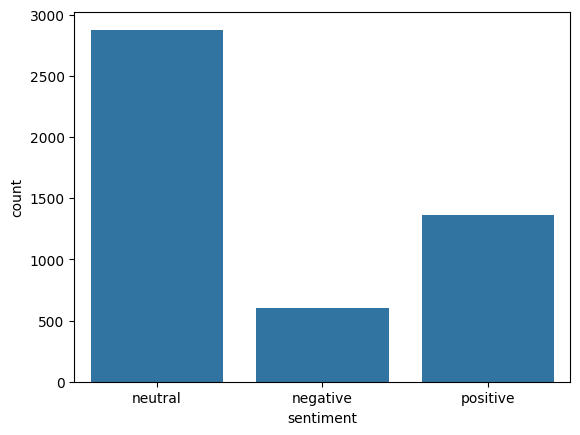

In [ ]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

In [ ]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['sentiment'])

In [ ]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [ ]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


109/109 ━━━━━━━━━━━━━━━━━━━━ 40s 299ms/step - accuracy: 0.5665 - loss: 0.9619 - val_accuracy: 0.6469 - val_loss: 0.8305
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.6421 - loss: 0.8000 - val_accuracy: 0.6675 - val_loss: 0.7475
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.7419 - loss: 0.6255 - val_accuracy: 0.7139 - val_loss: 0.7326
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.8454 - loss: 0.4206 - val_accuracy: 0.7320 - val_loss: 0.7561
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.9121 - loss: 0.2688 - val_accuracy: 0.7371 - val_loss: 0.7604
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9332 - loss: 0.2173 - val_accuracy: 0.7320 - val_loss: 0.9185
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 0.9514 - loss: 0.1543 - val_accuracy: 0.7397 - val_loss: 1.0317
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.9596 - loss: 0.1368 - val

**UNDERSAMPLING**

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Inicializar o RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # random_state para reprodutibilidade

# Aplicar o undersampling aos dados de treino
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_pad, y_train)

In [ ]:
# Treinar o modelo com os dados balanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.9324 - loss: 0.2626 - val_accuracy: 0.8966 - val_loss: 0.2420
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 379ms/step - accuracy: 0.9611 - loss: 0.1319 - val_accuracy: 0.9241 - val_loss: 0.2377
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9721 - loss: 0.0996 - val_accuracy: 0.8966 - val_loss: 0.2809
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9745 - loss: 0.0943 - val_accuracy: 0.9172 - val_loss: 0.2342
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9778 - loss: 0.0777 - val_accuracy: 0.8966 - val_loss: 0.2851
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.9820 - loss: 0.0572 - val_accuracy: 0.9034 - val_loss: 0.3249
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9856 - loss: 0.0514 - val_accuracy: 0.8552 - val_loss: 0.3836
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9807 - loss: 0.0613 - val_accuracy: 0.896

<Axes: xlabel='label_encoded', ylabel='count'>

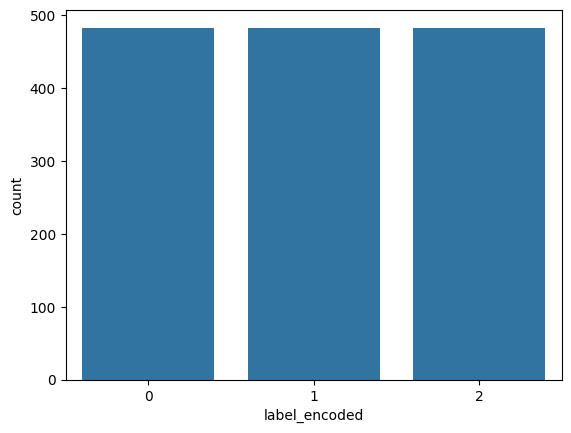

In [ ]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [ ]:
# prompt: acuracia, recall e f1-score

import numpy as np
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       121
           1       0.81      0.75      0.78       576
           2       0.64      0.59      0.61       273

    accuracy                           0.70       970
   macro avg       0.64      0.68      0.65       970
weighted avg       0.72      0.70      0.70       970



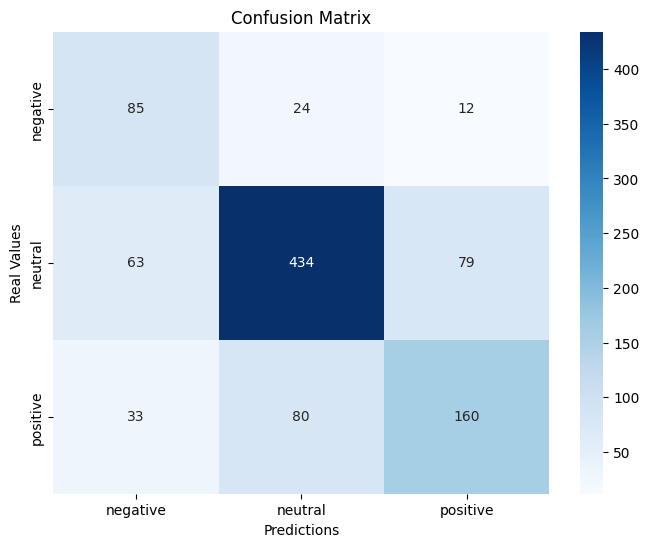

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=03d4f65e4943a8c1b44a12ee04a2af18c4bdd6d06eba5b1665f89b43d3703c42
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import numpy as np
from lime import lime_text
from sklearn.pipeline import make_pipeline
from tensorflow.keras import backend as K  # Importar backend do Keras

# Criar um pipeline com o tokenizador e o modelo
pipeline = make_pipeline(tokenizer, model)

# Criar um explicador LIME
explainer = lime_text.LimeTextExplainer(class_names=le.classes_)

# Função para obter as probabilidades (substitui predict_proba)
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    probabilities = K.softmax(tf.convert_to_tensor(predictions)).numpy()  # Aplicar softmax e converter para numpy
    return probabilities

# Selecionar um exemplo para explicar
idx = 0
example = X_test.iloc[idx]
true_class = y_test.iloc[idx]  # Obter a classe verdadeira do exemplo

# Imprimir o exemplo e a classe verdadeira
print(f"Original text: {example}")
print(f"Royal class: {le.classes_[true_class]}")  # Usar le.classes_ para obter o nome da classe

# Gerar a explicação
exp = explainer.explain_instance(example, predict_proba, num_features=10)

# Mostrar a explicação
print(exp.as_list())
exp.show_in_notebook(text=True)

Original text: juhani jrvi corporate executive vice president kesko say russian food retail sector fragmented
Royal class: neutral
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step
[(np.str_('vice'), 0.07984281666726742), (np.str_('president'), 0.05681337439229613), (np.str_('corporate'), 0.05498394539822532), (np.str_('kesko'), -0.048143896565918554), (np.str_('executive'), -0.026328347435872364), (np.str_('say'), -0.02105463636882399), (np.str_('russian'), -0.017449607850553495), (np.str_('juhani'), 0.010552142038141896), (np.str_('sector'), -0.009020293640259454), (np.str_('retail'), 0.006707120110776588)]


In [ ]:
# Obter as palavras mais importantes e seus pesos
words_weights = exp.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

vice: 0.07984281666726742
president: 0.05681337439229613
corporate: 0.05498394539822532
kesko: -0.048143896565918554
executive: -0.026328347435872364
say: -0.02105463636882399
russian: -0.017449607850553495
juhani: 0.010552142038141896
sector: -0.009020293640259454
retail: 0.006707120110776588


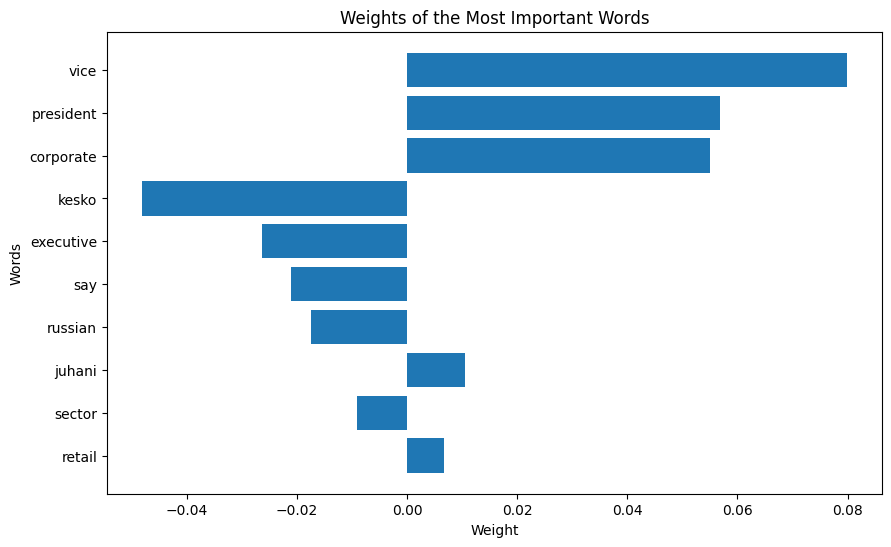

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obter as palavras mais importantes e seus pesos
words_weights = exp.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [ ]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
# Obter os pesos da camada de Embedding
embedding_weights = model.layers[0].get_weights()[0]  # A primeira camada é a Embedding

# Using tokenizer.index_word to get words from indices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense
dense_weights = model.layers[-1].get_weights()[0]  # A última camada é a Dense

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

In [ ]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Weight', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
            Feature    Weight
609          sponda  0.852912
65         increase  0.826897
4911     assessment  0.707120
495            life  0.682550
1019      container  0.657487
575            date  0.630306
3257          agent  0.616221
32            plant  0.583873
1218    outstanding  0.561629
2173         nexbtl  0.561539
64             rose  0.555102
850           study  0.548897
1567             pc  0.543953
66             part  0.540578
672            vice  0.533632
1499          frame  0.523774
228            food  0.513360
4167  yekaterinburg  0.510200
4327           temv  0.506118
4              said  0.504461


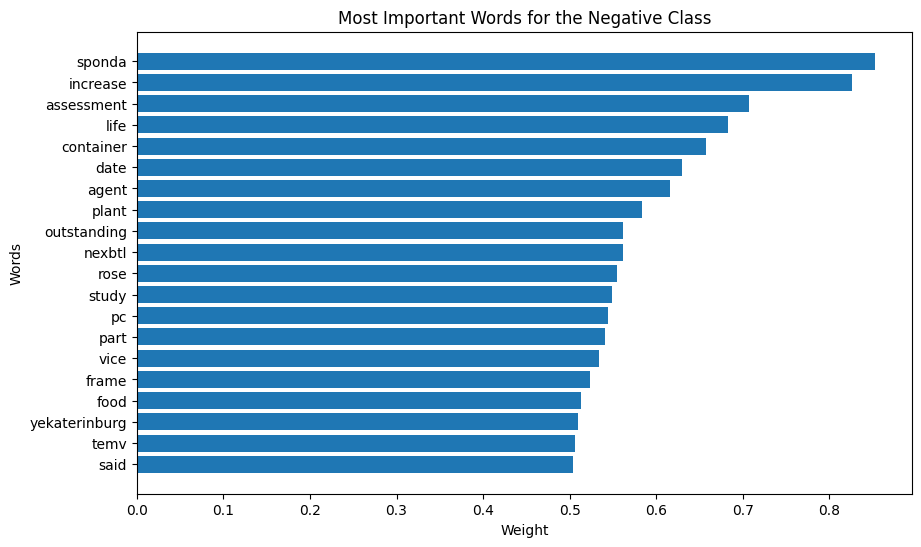

In [ ]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [ ]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Weight', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
          Feature    Weight
100        annual  1.806761
254          site  1.407208
139      totalled  1.317764
693     norwegian  1.300201
463      resource  1.230514
1072  consultancy  0.982614
720         still  0.945328
399            uk  0.916031
749          book  0.913785
357   teliasonera  0.898933
1332         grow  0.876604
174         power  0.834990
3104       belief  0.826924
2197    pipettors  0.816313
1090        aimed  0.805194
2536    resulting  0.799427
3762     uncoated  0.792050
56          price  0.785054
733        biohit  0.780417
2778      bristol  0.774033


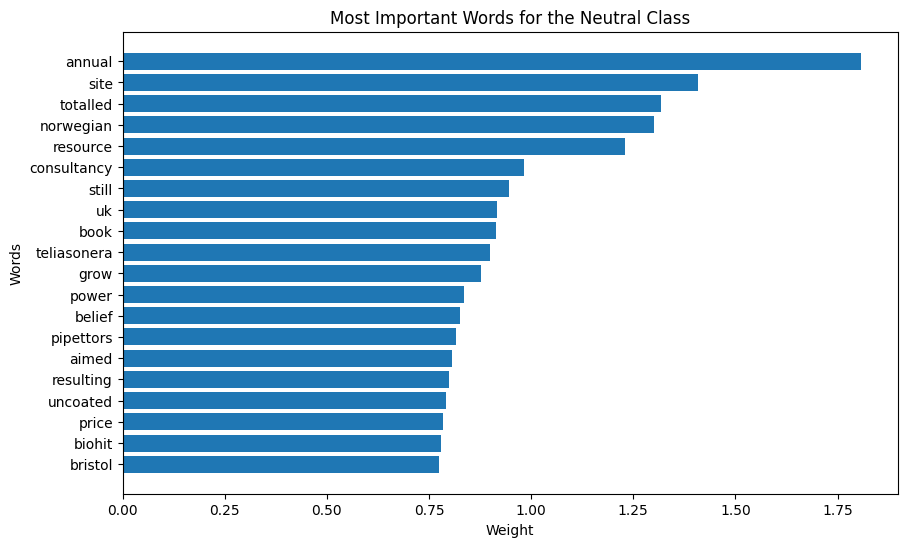

In [ ]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [ ]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Weight', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
          Feature    Weight
0           <OOV>  1.042372
181          mill  1.006599
163       largest  0.986497
149     estimated  0.971650
173   negotiation  0.937371
188        baltic  0.859146
2263      highest  0.814766
1437       single  0.810766
481       handset  0.807955
1832    amendment  0.797951
1707        intel  0.782421
998      estonian  0.768465
122     including  0.766297
341          real  0.764062
462       scanfil  0.763990
123       revenue  0.760301
283       holding  0.755312
467           afx  0.752831
646    department  0.736611
338            ab  0.732394


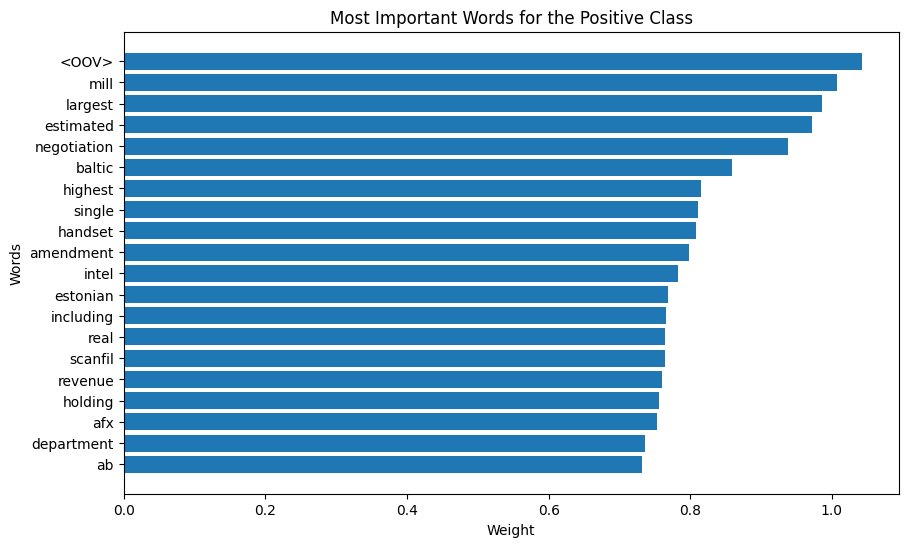

In [ ]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()